# Sentiment Analysis

In this notebook, I will conduct sentiment analysis on Amazon video games reviews in hopes of gaining practical experience and insights into natural language processing. 

---

## Libraries

In [1]:
# Data Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# NLP Text Libraries
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /Users/yumin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yumin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yumin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# EDA Analysis
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

In [4]:
# Feature Engineering
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

In [73]:
# Model Selection and Evaluation
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
     

## Dataset
Dataset used in this investigation can be found here: [Amazon review data](https://nijianmo.github.io/amazon/index.html)

In [6]:
dataset = pd.read_json("/Users/yumin/Documents/GitHub/SentimentAnalysis/Video_Games_5.json", lines=True)

In [7]:
dataset.shape

(497577, 12)

## Data Processing

In [8]:
# Checking for null values
dataset.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          76
reviewText           158
summary              109
unixReviewTime         0
vote              389784
style             208340
image             493943
dtype: int64

From above, there are three main columns in the dataset with null values: "reviewerName", "reviewText", and "summary".
While reviewerName is not very important to sentiment analysis, rows with null reviewText and summary values cannot be dropped because as long as one of the values are present, each row will affect the model accuracy. Instead, rows with missing values were filled with empty string.

In [9]:
# Filling missing values 
dataset.reviewText.fillna(value="", inplace = True)
dataset.summary.fillna(value="", inplace = True)

In [10]:
# Drop irrelevant columns
dataset.drop(columns = ["vote", "style", "image"], axis = 1, inplace = True)

In [11]:
# Concat "reviewText" with "summary"
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

In [12]:
# Static Description of the Dataset
dataset.describe(include = "all")

,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,reviews
count,497577.000000,497577,497577,497577,497577,497501,4.975770e+05,497577
unique,NaN,2,6847,55223,17408,45943,NaN,409512
top,NaN,True,"12 29, 2014",A3V6Z4RCDGRC44,B00178630A,Amazon Customer,NaN,good Five Stars
freq,NaN,332645,528,815,1381,15731,NaN,1594
mean,4.220456,NaN,NaN,NaN,NaN,NaN,1.367848e+09,NaN
std,1.185424,NaN,NaN,NaN,NaN,NaN,1.224113e+08,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,9.398592e+08,NaN
25%,4.000000,NaN,NaN,NaN,NaN,NaN,1.316563e+09,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,1.410221e+09,NaN
75%,5.000000,NaN,NaN,NaN,NaN,NaN,1.452384e+09,NaN


Overall ratings range from [1, 5] as shown above, with an average of 4.22.
The new concatenated column "reviews" can be observed.

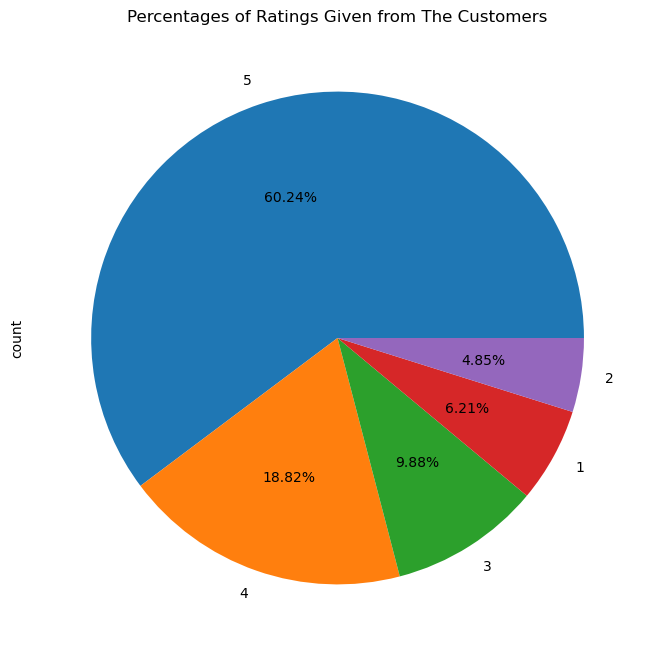

In [13]:
# Percentages of Ratings Given from the Customers
dataset.overall.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()

From chart above, it can be inferred that majority of video games sold on Amazon have perfect ratings 5.0.\
Let's assume the following:
- overall > 3 = Positive
- overall == 3 = Neutral
- overall < 3 = Negative

In [14]:
# Labelling Products Based on Ratings Given
def Labelling(Rows):
    if(Rows["overall"] > 3.0):
        Label = "Positive"
    elif(Rows["overall"] == 3.0):
        Label = "Neutral"
    else:
        Label = "Negative"
    return Label

In [15]:
dataset["sentiment"] = dataset.apply(Labelling, axis=1)

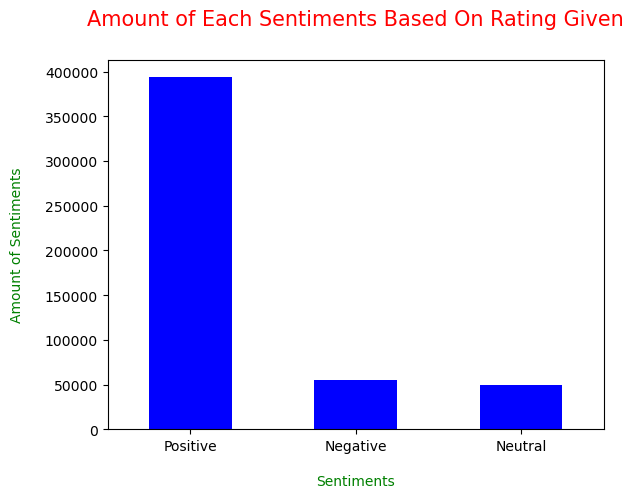

In [16]:
dataset["sentiment"].value_counts().plot(kind = "bar", color = "blue")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.show()

Our analysis on converting numeric review data into sentiment shows high degree of positive reviews, which is true under the case that our assumption on categorization of sentiments is valid. 

## Text Preprocessing

In [17]:
# Text cleaning
def Text_Cleaning(Text):
    # Lowercase the texts
    Text = Text.lower()

    # Cleaning punctuations in the text
    punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    Text = Text.translate(punc)

    # Removing numbers in the text
    Text = re.sub(r'\d+', '', Text)

    # Removing possible links
    Text = re.sub('https?://\S+|www\.\S+', '', Text)

    # Deleting newlines
    Text = re.sub('\n', '', Text)

    return Text

In [18]:
# Text processing
# Stopwords called from nltk except "not"
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
    Processed_Text = list()
    Lemmatizer = WordNetLemmatizer()

    # Token of words
    Tokens = nltk.word_tokenize(Text)

    # Removing Stopwords and Lemmatizing Words
    # To reduce noises in our dataset, also to keep it simple and still 
    # powerful, we will only omit the word `not` from the list of stopwords

    for word in Tokens:
        if word not in Stopwords:
            Processed_Text.append(Lemmatizer.lemmatize(word))

    return (" ".join(Processed_Text))

What is Lemmatization?
"Lemmatization is a text pre-processing technique used in natural language processing (NLP) models to break a word down to its root meaning to identify similarities. For example, a lemmatization algorithm would reduce the word *better* to its root word, or lemme, *good*." - [Source](https://builtin.com/machine-learning/lemmatization#:~:text=Lemmatization%20is%20a%20text%20pre,word%2C%20or%20lemme%2C%20good.)

In [20]:
# Applying the functions
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))

## Exploratory Data Analysis

In [21]:
# Overview of the Dataset
dataset.head(n = 10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,reviews,sentiment
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,1445040000,game bit hard get hang great great,Positive
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,1437955200,played alright steam bit trouble move game ste...,Positive
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,1424649600,ok game three star,Neutral
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,1424390400,found game bit complicated not expected played...,Negative
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,1419465600,great game love played since arrived love game,Positive
5,4,True,"11 13, 2014",A11V6ZJ2FVQY1D,0700026657,IBRAHIM ALBADI,1415836800,liked lot time play wonderfull game simply fun...,Positive
6,1,False,"08 2, 2014",A1KXJ1ELZIU05C,0700026657,Creation27,1406937600,avid gamer anno insult gaming buggy half finis...,Negative
7,5,True,"03 3, 2014",A1WK5I4874S3O2,0700026657,WhiteSkull,1393804800,bought game thinking would pretty cool might p...,Positive
8,5,True,"02 21, 2014",AV969NA4CBP10,0700026657,Travis B. Moore,1392940800,played old anno game look great complex previo...,Positive
9,4,True,"06 27, 2013",A1EO9BFUHTGWKZ,0700026657,johnnyz3,1372291200,liked fun played got money worth certainly go ...,Positive


"reviews" will be an important feature to the sentiment analysis model. The use of this feature will allow us to classify what the sentiment for each review is.

Now, a closer look into the dataset on different aspects which may justify the result of sentiment analysis which is to be conducted.

In [22]:
# Polarity
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

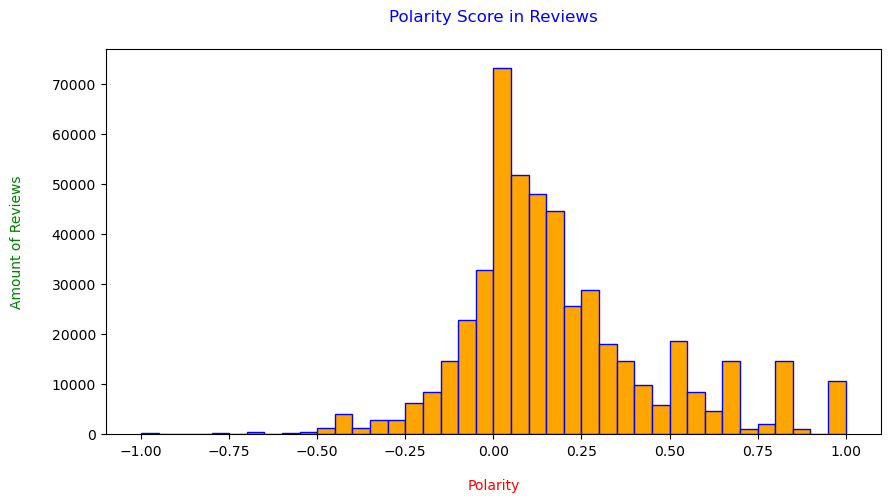

In [23]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10, 5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

Reviews with negative polarity are in range [-1, 0), neutral 0.0, and positive polatiry in range (0, 1].

From the histogram above, we know most of the reviews are distributed in positive polatiry domain, meaning that our inference from the analysis on sentiments based on numeric reviews is in alignment. Although the histogram shows a negatively skewed distribution, there are also observable spikes on the positive ends— notably at every third bar starting from polarity of 0.50.

In [24]:
# Review Length
dataset["length"] = dataset["reviews"].astype(str).apply(len)

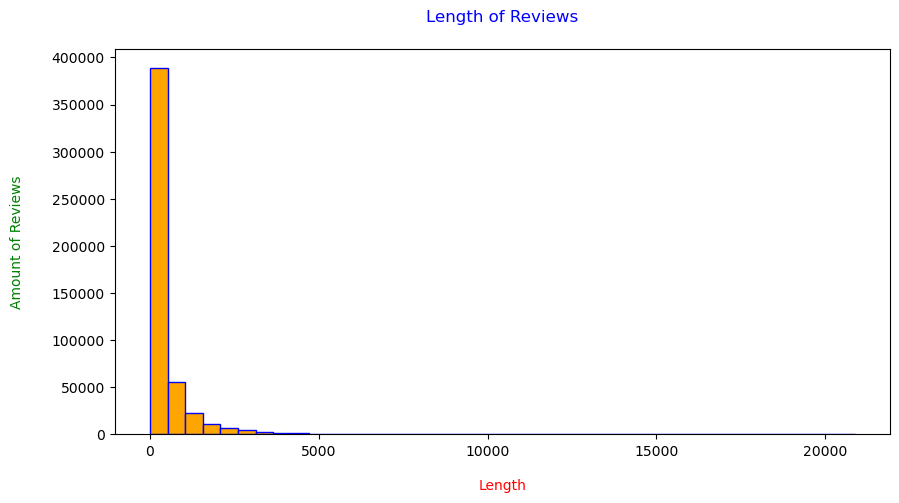

In [25]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10, 5))
plt.title("Length of Reviews", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

Based on the histogram above, it can be observed that the review has text length between approximately 0-5000 characters. The distribution has positive skewness which means that the reviews rarely has larger length than 1000 characters. However, the review length is affected by the text preprocessing phase, where text was cleared of puncuationa, links, numbers, stopwords, etc. The length, therefore, may not accurately represent the actual value of the review itself. 

In [26]:
# Word Counts
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

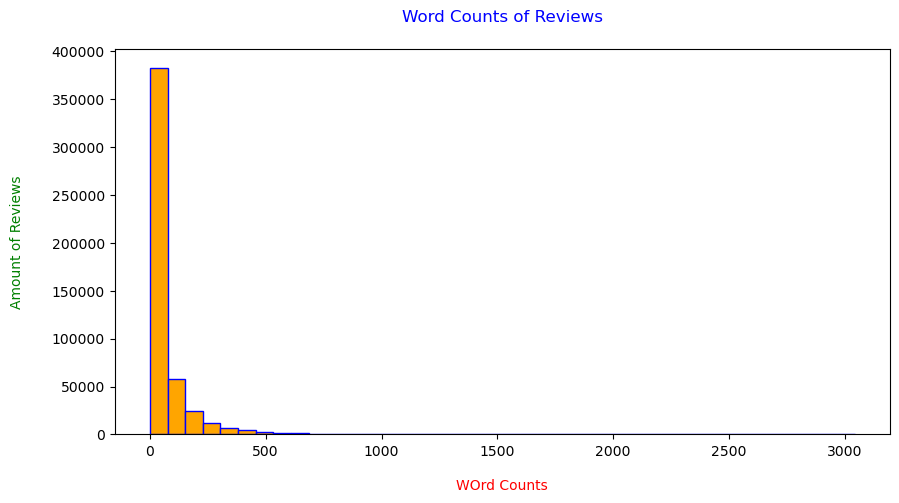

In [27]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10, 5))
plt.title("Word Counts of Reviews", color = "blue", pad = 20)
plt.xlabel("WOrd Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

From the figure above, we can infer that most of the reviews consist of 0-200 words, subject to the effects of text preprocessing phase.

## N-Gram Analysis

In [28]:
# N-Gram Function
def Gram_Analysis(Corpus, Gram, N):
    # Vectorizer
    Vectorizer = CountVectorizer(stop_words = list(Stopwords), ngram_range=(Gram,Gram))

    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)

    # N-Grams Frequency
    Count = ngrams.sum(axis=0)

    # List of Words
    words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

    # Sort Descending With Key = Count
    words = sorted(words, key = lambda x:x[1], reverse = True)

    return words[:N]

In [29]:
# Filtering the dataframe based on sentiments
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

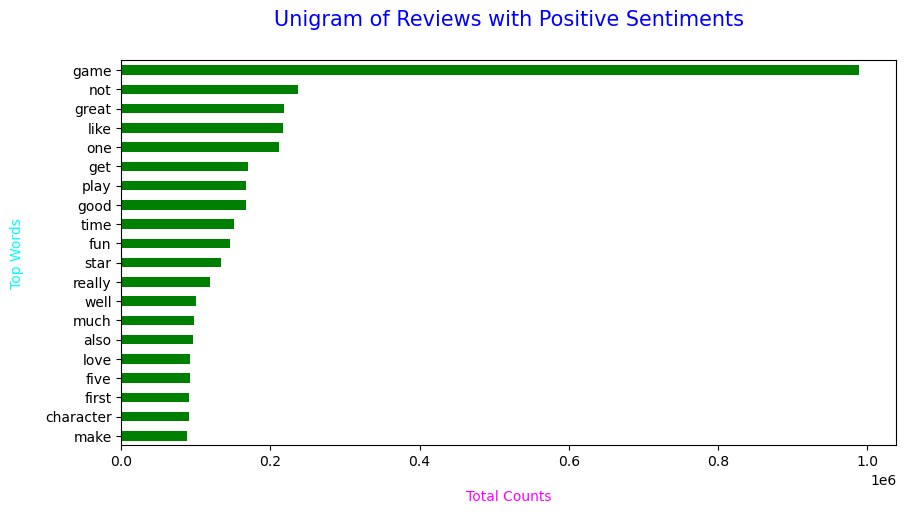

In [30]:
# Unigram of Reviews Based on Sentiments
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

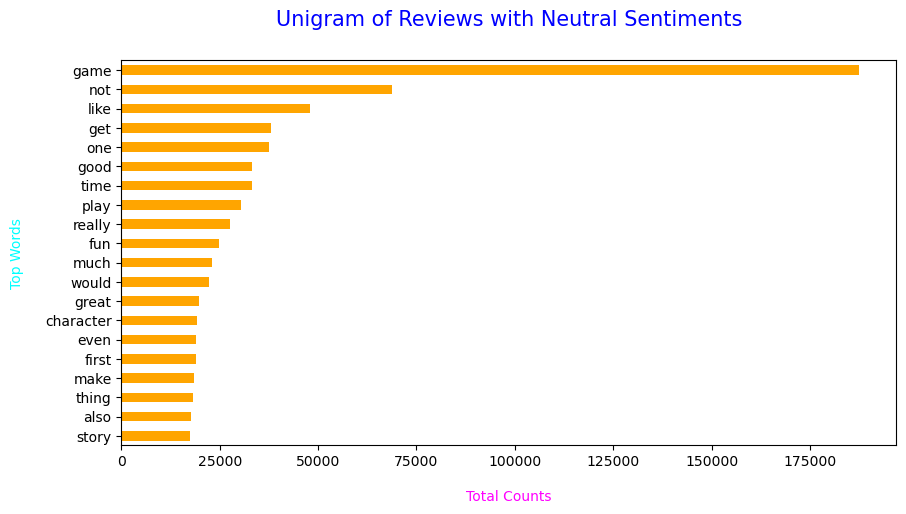

In [31]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

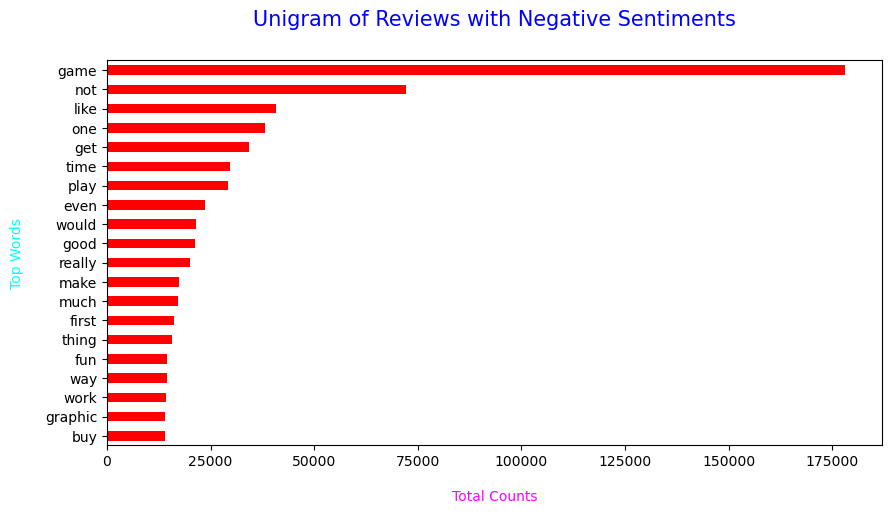

In [32]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

These unigrams may not be very accurate, because for all three sentiments, the top words include "game" and "not". These alone do not reflect useful measures to analyze the sentiments. We should try to find the bigram and see how accurate it can describe each sentiments.

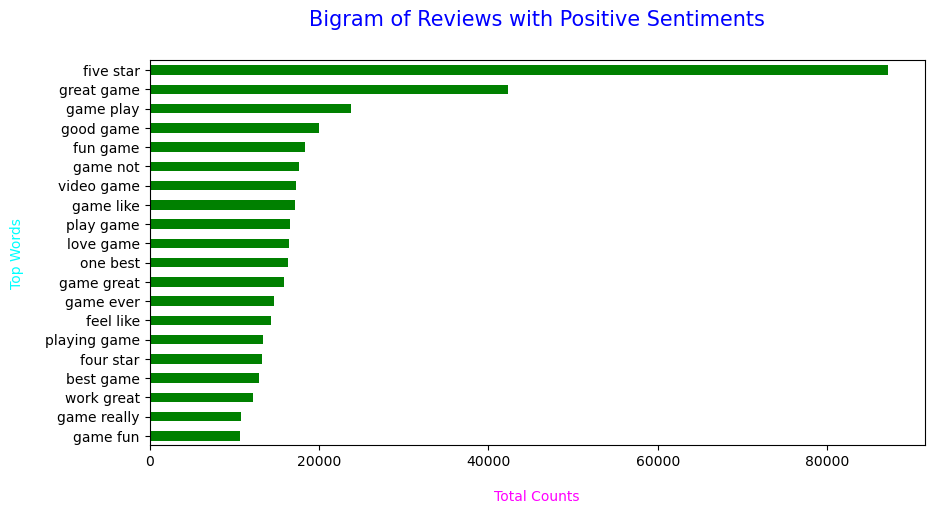

In [33]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

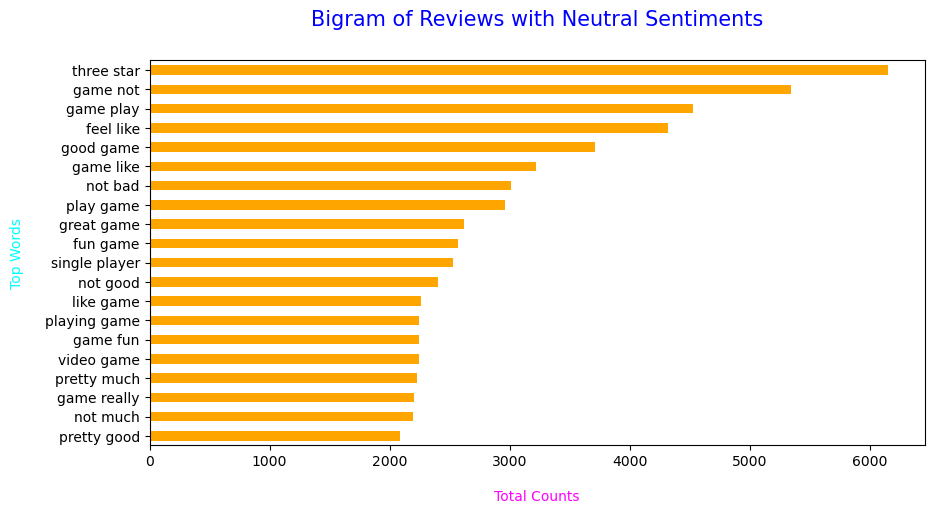

In [34]:
# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

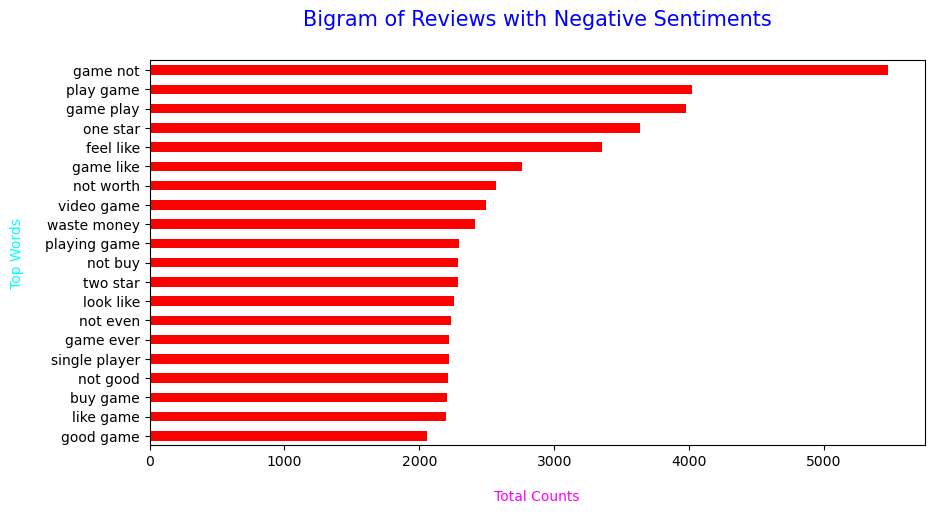

In [35]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

The bigrams work better than the unigrams, because we can actually see some phrases such as "great game", "fun game", and "five star" that describe what a good sentiment is. 

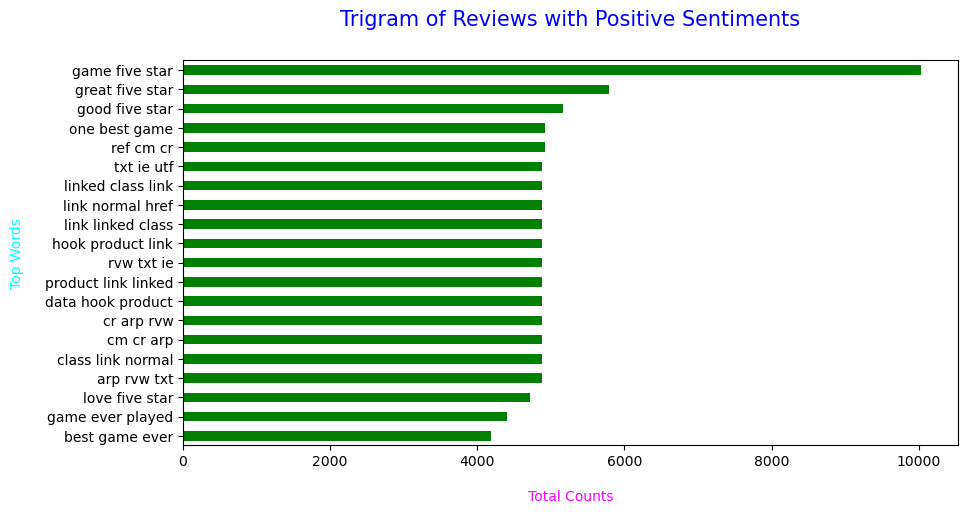

In [36]:
# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

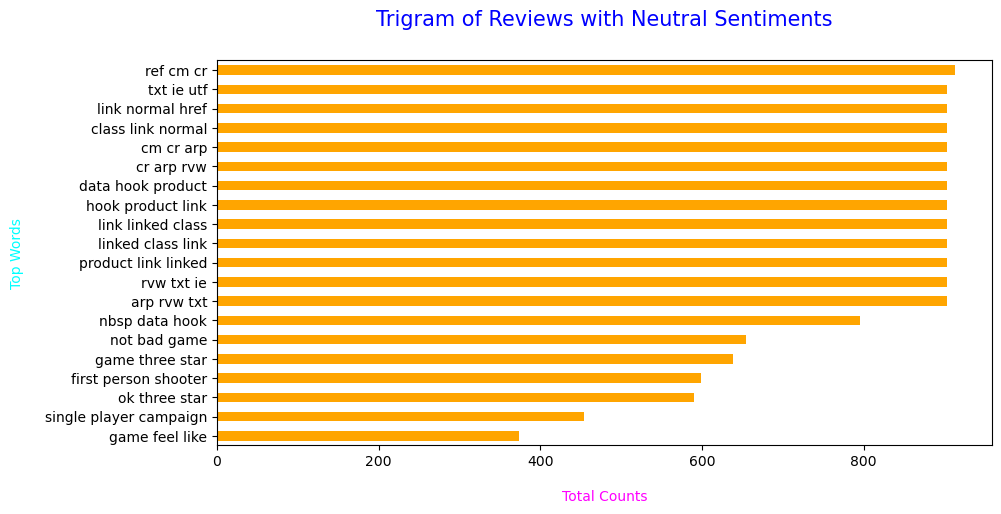

In [37]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

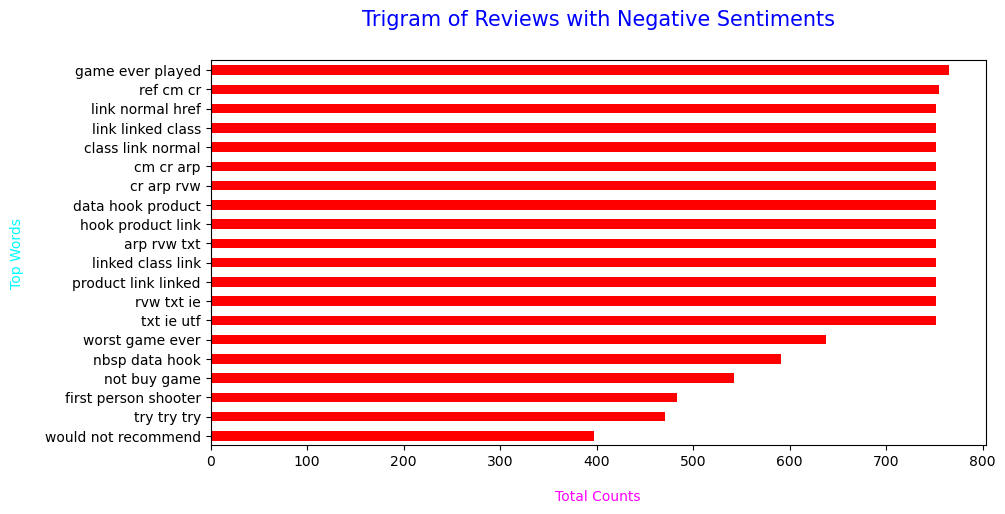

In [38]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

**In the trigrams above, a paculiar observation of weird phrases "ref cm cr", "arp rvw txt" which we would not expect to see in reviews is made. Will have to look into the issue.**

## Word Clouds

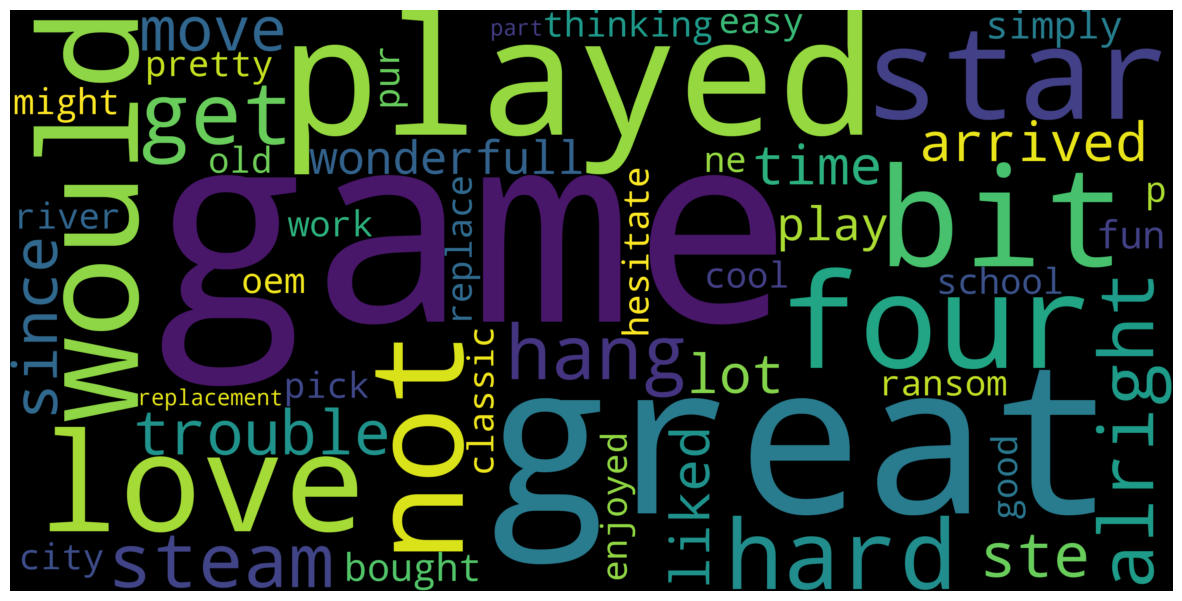

In [39]:
# Word cloud of reviews with positive sentiments
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

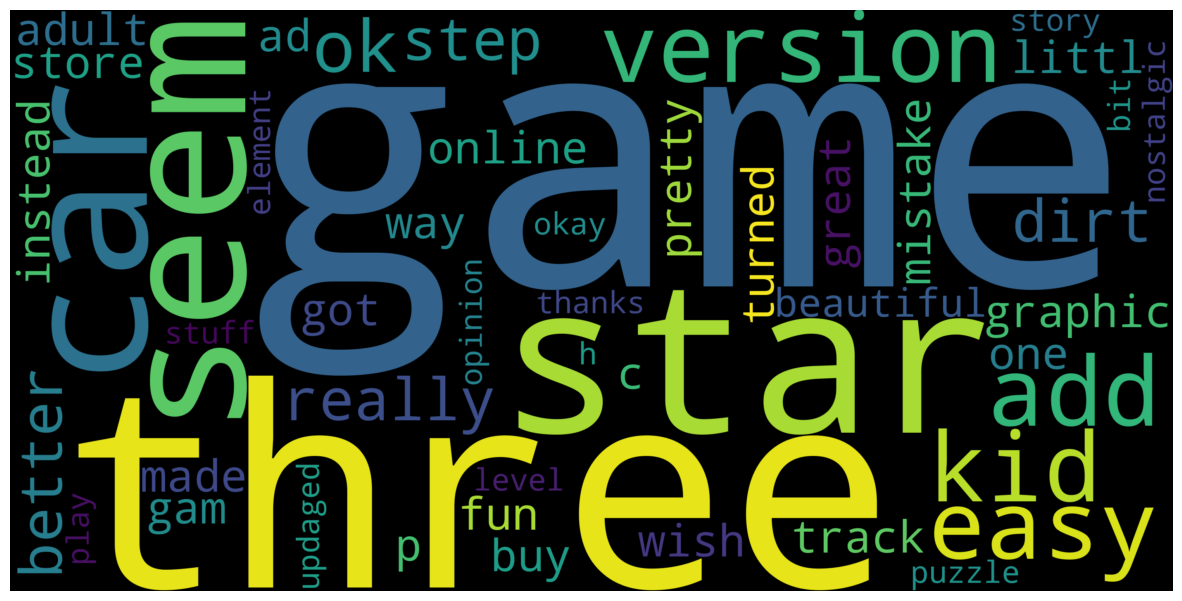

In [40]:
# Word cloud of reviews with neutral sentiments
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

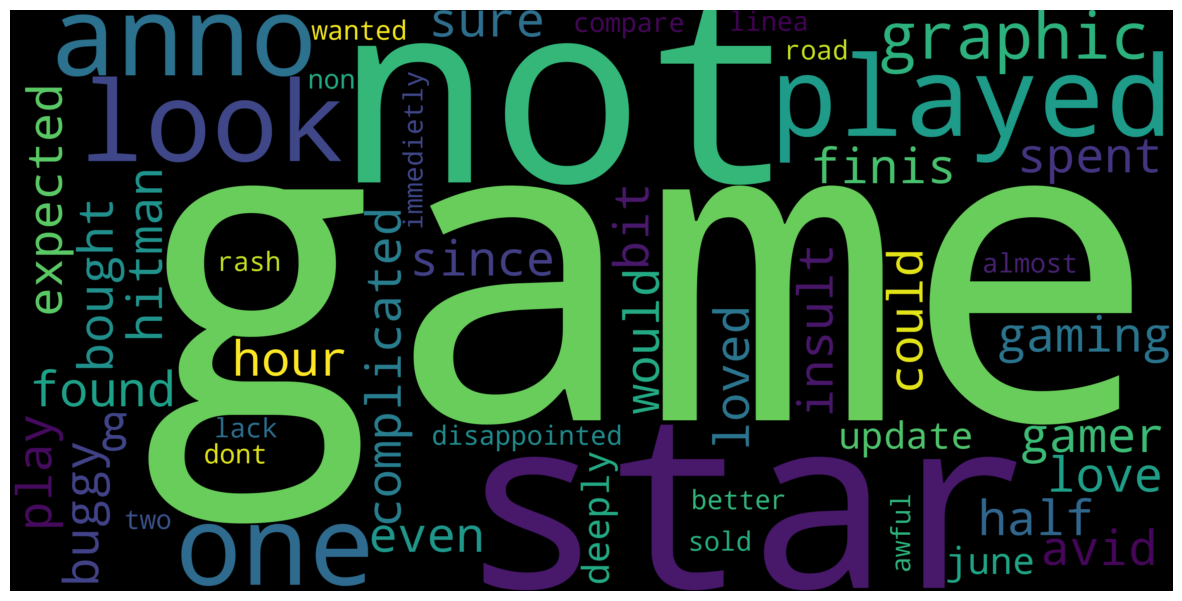

In [41]:
# Word cloud of reviews with negative sentiments
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

## Feature Engineering

In [42]:
dataset.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'unixReviewTime', 'reviews', 'sentiment', 'polarity',
       'length', 'word_counts'],
      dtype='object')

In [43]:
# Dropping insignificant columns
Columns = ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'unixReviewTime', 'polarity',
       'length', 'word_counts']
dataset.drop(columns = Columns, axis = 1, inplace = True)

In [44]:
# Current state of the dataset
dataset.head()

,reviews,sentiment
0,game bit hard get hang great great,Positive
1,played alright steam bit trouble move game ste...,Positive
2,ok game three star,Neutral
3,found game bit complicated not expected played...,Negative
4,great game love played since arrived love game,Positive


In [45]:
# Encoding our target variable
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])
dataset["sentiment"].value_counts()

sentiment
2    393413
0     55018
1     49146
Name: count, dtype: int64

Sentiment was encoded into numbers so that the model can easily figure it out. From above, we know that the label "Positive" is encoded into 2, "Neutral" into 1, and "Negative" into 0. Now, we have to give weight of each words in the whole review. This is done by using TF-IDF(Term Frequency - Inverse Document Frequency) Vectorizer. Prior the Vectorization, the data will be downsampled to ensure the computing power can handle the data.

In [65]:
# Downsampling the dataset to run K-Fold Cross validation
dataset_downsampled = dataset.sample(frac = 0.02, random_state = 42, axis = 0)
dataset_downsampled.shape

(9952, 2)

In [66]:
# TF-IDF Vectorizer
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset_downsampled["reviews"])

# Check our matrix shape
X.shape

(9952, 5000)

In [67]:
# Declaring our target variable
y = dataset_downsampled["sentiment"]

From the shape, we successfylly transformed our review with TF-IDF Vectorizer of 5000 top bigram words. Now, as we know from before, our data is imbalanced with very little neutral and negative values compared to positive sentiments. We need to balance our dataset before going into modelling process.

In [68]:
# Resampling our dataset using SMOTE(Synthetic minority oversampling technique)
Counter(y)

Counter({2: 7840, 0: 1132, 1: 980})

In [69]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X,y)

In [70]:
Counter(y_final)

Counter({2: 7840, 1: 7840, 0: 7840})

In [71]:
# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

## Model Selection and Evaluation

K-Fold Cross validation techniques were used to find the best model. The technique was used on early dataset(before resampling) because the CV is not affected by the imbalanced dataset as it splits the dataset and takes into account every validations. 

In [74]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.7697955641662125
Logistic Regression Test Accuracy: 0.829983552299651
SVC Test Accuracy: 0.8215428548364312
Random Forest Test Accuracy: 0.8271708946338118
Naive Bayes Test Accuracy: 0.7308094690319065
K-Neighbors Test Accuracy: 0.8033546245282638


It can be observed that the results of 10-Fold Cross Validation suggests that Logistic Regression yields the highest accuracy, slightly beating the Random Forest Model. We will further develop the Logistic Regression model to predict our sentiment with tuning of parameters.

**It is to be further evaluated the extent to which the K-Fold Cross validation method carried out on the downsampled data accurately captures the model's performance on the entire dataset**

In [75]:
# Hyperparameter Tuning
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/Users/yumin/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yumin/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best Accuracy: 91.59 %
Best Parameters: {'C': 2222.996482526191, 'penalty': 'l2'}


/Users/yumin/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Achieved an accuracy of 91.59%, and grid search was able to find the optimal hyperparameters. Applying the hyperparameters to the model:

In [76]:
Classifier = LogisticRegression(random_state = 42, C = 2222.996482526191, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

/Users/yumin/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
# Metrics
accuracy_score(y_test, Prediction)

0.9219387755102041

In [78]:
# Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test, Prediction)

In [79]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")
  
  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


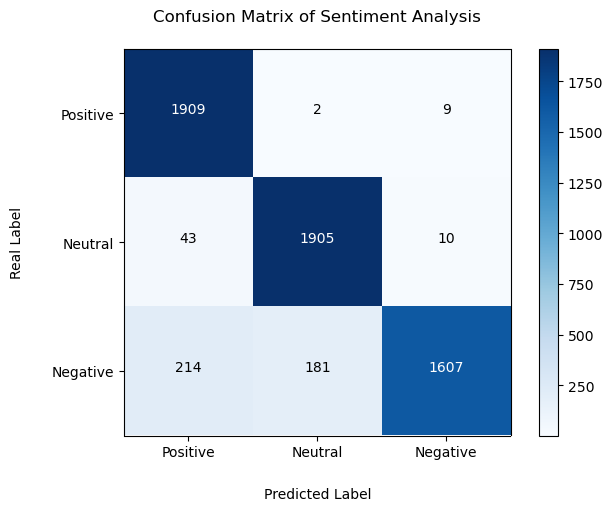

In [80]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

The confusion matrix, along with the high accuracy score suggests the model works well. It is able to categorize both positive and neutral sentiments correctly, while it seems to struggle at determining negative sentiments. This may, in part, be due to the effect of imbalanced data from the original dataset, and luckily we could minimize the effect by using SMOTE resampling.

In [81]:
# Classification Scores
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1920
           1       0.91      0.97      0.94      1958
           2       0.99      0.80      0.89      2002

    accuracy                           0.92      5880
   macro avg       0.93      0.92      0.92      5880
weighted avg       0.93      0.92      0.92      5880



Overall, to each of our sentiment categories, we got F1 Score of 92%.

---

## Conclusion

**Dataset**
1. Among many columns in the original data, very few including "reviewText", "summary", etc were used to carry out sentiment analysis.
2. Stop words which were omitted in the text-preprocessing phase may include important words to analyze user sentiments.

**Model**
1. The accuracy of the sentiment model is only as accurate as the assumption that reviews of over 3 stars is positive, 3 is neutral, and less than 3 is negative.
2. The observable failure of the Trigram catching non-english phrases to be associated with certain sentiments has to be addressed through further research.
   